In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
year_start = 1998
year_end = 2018
years_iter = range(year_start,year_end)

# Read cleaned data

- ## MSA data

In [3]:
df = {}
for year in years_iter:
    df[year] = pd.read_csv('data/cleaned/msa_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')
    
# used later to rank the MSA's by employment
df_2017 = df[2017].copy()

- ## State-country data

In [4]:
df_state = {}
for year in years_iter:
    df_state[year] = pd.read_csv('data/cleaned/state_naicssector_cleanedv2_totEmploy_'+str(year)+'.csv')

# Merge data

- ## MSA

In [5]:
for year in years_iter:
    df[year] = df[year].set_index(['MSA','NAICS Code'],drop=True)
    
tot_empl_all = df[year_start]
for year in range(year_start+1,year_end):
    tot_empl_all = pd.merge(tot_empl_all, df[year],how='inner' ,on=['MSA','NAICS Code'],copy=False )
    #df_all.to_csv('data/draft/df_all_merge_'+str(year)+'.csv')
    
tot_empl_all = tot_empl_all.T
tot_empl_all.index = list(years_iter)

- ## state-country

In [6]:
for year in years_iter:
    df_state[year] = df_state[year].set_index(['State','NAICS Code'],drop=True)

tot_empl_state_all = df_state[year_start]
for year in range(year_start+1,year_end):
    tot_empl_state_all = pd.merge(tot_empl_state_all, df_state[year],how='inner' ,on=['State','NAICS Code'],copy=False )
    
tot_empl_state_all = tot_empl_state_all.T
tot_empl_state_all.index = list(years_iter)

# Calculate PPC: point percent change

- ## MSA

In [7]:
window_size = 2

tot_empl_ppc = tot_empl_all.pct_change().drop( tot_empl_all.index[0] )*100
tot_empl_ppc.loc[2003] = (tot_empl_ppc.loc[2002]+tot_empl_ppc.loc[2004])/2
#tot_empl_ppc = tot_empl_ppc.rolling(window=window_size,center=False).mean().drop( tot_empl_ppc.index[:window_size-1] )

- ## State-Country

In [8]:
tot_empl_state_ppc = tot_empl_state_all.pct_change().drop( tot_empl_state_all.index[0] )*100
tot_empl_state_ppc.loc[2003] = (tot_empl_state_ppc.loc[2002]+tot_empl_state_ppc.loc[2004])/2
#tot_empl_state_ppc = tot_empl_state_ppc.rolling(window=window_size,center=False).mean().drop( tot_empl_state_ppc.index[:window_size-1] )

# Utilities

- ## MSA to State 

In [9]:
MSA_df = pd.read_csv('data/MSA_wikipedia.csv',delimiter='\t')

MSAs = MSA_df['Metropolitan statistical area ']
MSA_shorts = MSAs.map(lambda x: x.split(',')[0].split('-')[0].lower() )
MSA_shorts_dict = {MSA_shorts.iloc[i]:
                   {'MSA': MSAs.iloc[i][:-1],
                    'State': MSAs.iloc[i].split(', ')[1].split(' ')[0] } for i in range(len(MSAs))  }


state_abbr_df = pd.read_csv('data/state_abbr.csv',delimiter='\t',names=['State','Abbr.'])
state_to_abbr_dict = { state_abbr_df['State'].iloc[i].title()[0:-1] :state_abbr_df['Abbr.'].iloc[i] for i in range(len(state_abbr_df)) }
state_to_abbr_dict['United States'] = 'US'

abbr_to_state_dict ={ v:k for k,v in state_to_abbr_dict.items()}

MSA_to_state_dict = { MSAs.iloc[i][:-1]: MSAs.iloc[i].split(', ')[1].split(' ')[0]  for i in range(len(MSAs))  }

- ## Compare MSA data to state and country data

In [10]:
def ppc_relative( MSA,NAICS_code ):
    return (tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( abbr_to_state_dict[MSA_to_state_dict[MSA]] ,NAICS_code) ],
            tot_empl_ppc[ (MSA,NAICS_code) ]-tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ] )

- ## NAICS Codes

In [11]:
NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter='    ')
NAICS_dict = { NAICS_df['NAICS Code'].iloc[i]:NAICS_df['Description'].iloc[i] for i in NAICS_df.index }
NAICS_dict['--'] = 'Total'
NAICS_dict

<ipython-input-11-48819ea87482>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  NAICS_df = pd.read_csv('data/NAICS_codes.csv',delimiter='    ')


{'11': 'Agriculture, Forestry, Fishing and Hunting',
 '21': 'Mining, Quarrying, and Oil and Gas Extraction',
 '22': 'Utilities',
 '23': 'Construction',
 '31-33': 'Manufacturing',
 '42': 'Wholesale Trade',
 '44-45': 'Retail Trade',
 '48-49': 'Transportation and Warehousing',
 '51': 'Information',
 '52': 'Finance and Insurance',
 '53': 'Real Estate and Rental and Leasing',
 '54': 'Professional, Scientific, and Technical Services',
 '55': 'Management of Companies and Enterprises',
 '56': 'Administrative and Support and Waste Management and Remediation Services',
 '61': 'Educational Services',
 '62': 'Health Care and Social Assistance',
 '71': 'Arts, Entertainment, and Recreation',
 '72': 'Accommodation and Food Services',
 '81': 'Other Services (except Public Administration)',
 '92': 'Public Administration',
 '99': 'Unclassified',
 '--': 'Total'}

- ## MSA rank by total Employment

In [12]:
msa_emp_rank_df =  df_2017[ df_2017['NAICS Code']=='--' ].sort_values(by='Total Employment - 2017',ascending=False).reset_index(drop=True)
del msa_emp_rank_df['NAICS Code'], msa_emp_rank_df['Total Employment - 2017']
msa_emp_rank_df_dict = {i:msa_emp_rank_df['MSA'].iloc[i] for i in range(len(msa_emp_rank_df))  }

- ## Print Info

# House data
- ## Read, clean and Calculate PPC

In [13]:
house_df = pd.read_csv('data/other-data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
del house_df['RegionID'], house_df['SizeRank'], house_df['RegionType'], house_df['StateName']
house_df.set_index('RegionName',drop=True,inplace=True)
house_df = house_df.T
house_df.index = pd.to_datetime(house_df.index)

house_df = house_df.rolling(12,center=True).mean()

house_df['Year'] = house_df.index.year
house_df = house_df.groupby(house_df['Year']).mean()
house_df = house_df.loc[ list( range(year_start,2020) ) ]

# calculate PPC
house_ppc_df = house_df.diff()/house_df.shift()*100
house_ppc_df = house_ppc_df.drop( house_ppc_df.index[0] )
#window_size = 2
#house_ppc_df = house_ppc_df.rolling(window=window_size,center=False).mean().drop( house_ppc_df.index[:window_size-1] )


- ## Some more utilities

In [14]:
def house_ppc_relative(MSA_rank):
    return house_ppc_df[house_ppc_df.columns[MSA_rank]]-house_ppc_df[house_ppc_df.columns[0]]

In [15]:
houseRank_to_empRank = {1:None, 2:0, 3:1, 4:2, 5:4, 6:5, 7:3, 8:8, 9:7,
                        10:6, 11:9, 12:None, 13:17, 14:12, 15:11, 16:10, 17:14, 18:15, 19:18 ,
                        20:16, 21:13, 22:19, 23:None, 24:22, 25:31, 26:26, 27:20, 28:24, 29:None, 30:23 }

In [16]:
def available_industries(MSA):
    code_list = list(tot_empl_all[MSA].columns)
    return pd.Series( [ NAICS_dict[ key ] for key in code_list ] , index=code_list )

def print_info(house_rank):
    print( "MSA: ", house_ppc_df.columns[ house_rank ] )
    if houseRank_to_empRank[house_rank] != None: 
        print( "Available Industires:\n", available_industries( msa_emp_rank_df_dict[ houseRank_to_empRank[house_rank] ] ) )
    else:
        print("Employment data no available at the moment")

- ## Compare PPC

- ## Compare Relative PPC

In [17]:
MSA_rank = 2
print_info(MSA_rank)

MSA:  Los Angeles-Long Beach-Anaheim, CA
Available Industires:
 --                                                   Total
11              Agriculture, Forestry, Fishing and Hunting
21           Mining, Quarrying, and Oil and Gas Extraction
22                                               Utilities
23                                            Construction
31-33                                        Manufacturing
42                                         Wholesale Trade
44-45                                         Retail Trade
48-49                       Transportation and Warehousing
51                                             Information
52                                   Finance and Insurance
53                      Real Estate and Rental and Leasing
54        Professional, Scientific, and Technical Services
55                 Management of Companies and Enterprises
56       Administrative and Support and Waste Managemen...
61                                    Educational S

## Poverty and income data

- ## Read and calculate PPC

In [18]:
poverty_df = pd.read_csv( 'data/saipe/poverty_percent_county_years_.csv',header=[0,1] ,index_col=0)
income_df = pd.read_csv('data/saipe/income_county_years_.csv',header=[0,1],index_col=0)

window_size = 2

poverty_df.dropna(axis=1,inplace=True)
poverty_ppc_df = poverty_df.pct_change()*100
poverty_ppc_df = poverty_ppc_df.drop( poverty_ppc_df.index[0] )
#poverty_ppc_df = poverty_ppc_df.rolling(window=window_size,center=False).mean().drop( poverty_ppc_df.index[:window_size-1] )

income_df.dropna(axis=1,inplace=True)
income_ppc_df = income_df.pct_change()*100
income_ppc_df = income_ppc_df.drop( income_ppc_df.index[0] )
#income_ppc_df = income_ppc_df.rolling(window=window_size,center=False).mean().drop( income_ppc_df.index[:window_size-1] )

In [19]:
def relative_ppc_poverty(MSA_rank):
    return -poverty_ppc_df[ houseRank_to_county[MSA_rank] ] + poverty_ppc_df['US','United States']

def relative_ppc_income(MSA_rank):
    return income_ppc_df[ houseRank_to_county[MSA_rank] ] - income_ppc_df['US','United States']

In [20]:
houseRank_to_county = {1:('US','United States'), 2:('CA','Los Angeles County'), 3:('IL','Cook County'), 4:('TX','Dallas County'), 5:('PA',''), 
                       6:('TX','Harris County'), 7:('DC','District of Columbia'), 8:('FL','Miami-Dade County'), 9:('GA','Fulton County'), 10:('MA','Suffolk County'), 
                       11:('CA','San Francisco County'), 12:('MI','Wayne County'), 13:('CA','Riverside County'), 14:('AZ','Maricopa County'), 15:('WA','King County'), 
                       16:('',''), 17:('CA','San Diego County'), 18:('',''), 19:('FL','Hillsborough County') ,  20:('MD','Baltimore city'), 
                       21:('CO','Denver County'), 22:('PA','Allegheny County'), 23:'NaN', 24:22, 25:('CA','Sacramento County'),
                       26:('TX','Bexar County'), 27:('FL','Orange County')
                        }

- ## Plots

In [50]:
available_MSAs = [2,4,6,8,9,11,13,14,15,17,19,20,21,22,25,26,27]
NAICS_codes_sig =  [ '--','11', '23','31-33','42','44-45','48-49','51','52','53','54','62','71','72' ]
MSA_rank = 2
MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]
print_info(MSA_rank)

MSA:  Los Angeles-Long Beach-Anaheim, CA
Available Industires:
 --                                                   Total
11              Agriculture, Forestry, Fishing and Hunting
21           Mining, Quarrying, and Oil and Gas Extraction
22                                               Utilities
23                                            Construction
31-33                                        Manufacturing
42                                         Wholesale Trade
44-45                                         Retail Trade
48-49                       Transportation and Warehousing
51                                             Information
52                                   Finance and Insurance
53                      Real Estate and Rental and Leasing
54        Professional, Scientific, and Technical Services
55                 Management of Companies and Enterprises
56       Administrative and Support and Waste Managemen...
61                                    Educational S

In [23]:
NAICS_code = '--'
ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
house_ppc_relative(MSA_rank)


In [40]:
#ppc_relative_country
house_ppc_relative(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values

array([  1.15228322,   2.2616642 ,   3.65815492,   5.7433837 ,
        10.26725076,  16.63117116,  15.50893525,   5.44100332,
        -3.28812701, -16.83779024, -17.69525293,  -0.61410168,
         2.42790778,   1.71912517,  12.21029542,  11.56142221,
         1.11534061,   0.92927852,   0.66086375])

In [23]:
NAICS_code = '--'

fig = plt.figure()
fsize = 6
plt.gcf().set_size_inches(fsize*2,fsize)

year_range = year_end-year_start-1
lag = 0
for MSA_rank in available_MSAs:
    MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]
    
    ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
    x=ppc_relative_country.values[:year_range-lag]
    
    plt.subplot(121)
    y=house_ppc_relative(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
    plt.scatter( x,y )
    
    plt.subplot(122)
    y=relative_ppc_poverty(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
    plt.scatter( x,y )

NameError: name 'available_MSAs' is not defined

<Figure size 864x432 with 0 Axes>

In [32]:
NAICS_code = '54'
print( NAICS_dict[NAICS_code] )

year_range = year_end-year_start-1
for lag in range( int(year_range) ):
    fig = plt.figure()
    fsize = 6
    plt.gcf().set_size_inches(fsize*2,fsize)

    emp_relppc_s = []
    house_relppc_s = []
    poverty_relppc_s = []
    
    for MSA_rank in available_MSAs:
        MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]
        
        
        if NAICS_code in list(tot_empl_all[MSA].columns):
            ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
            x=ppc_relative_country.values[:year_range-lag]
            emp_relppc_s += list(x)

            plt.subplot(121)
            y1=house_ppc_relative(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
            plt.scatter( x,y1 )
            house_relppc_s += list(y1)

            plt.subplot(122)
            y2=relative_ppc_poverty(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
            plt.scatter( x,y2 )
            poverty_relppc_s += list(y2)
            
    print('Lag = {} '.format(lag), pearsonr(emp_relppc_s,house_relppc_s),pearsonr(emp_relppc_s,poverty_relppc_s) )
    
    plt.close()

Professional, Scientific, and Technical Services
Lag = 0  (0.14424118617320927, 0.014804450158424352) (0.12372391949398245, 0.03683864374104193)


<ipython-input-32-2b54fcb76460>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-32-2b54fcb76460>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


Lag = 1  (0.13711995235979796, 0.024239548305978995) (0.008257091511642169, 0.8925718044662494)
Lag = 2  (0.1124532745930971, 0.07303652946133038) (0.08059023368830191, 0.19960160039815986)
Lag = 3  (0.02978446299291954, 0.6461538879122724) (-0.025256515588397338, 0.697060455374101)
Lag = 4  (-0.13920170105544827, 0.03692747152941683) (0.032871635323396875, 0.6238078786197612)
Lag = 5  (-0.16191954829280553, 0.018877205834938886) (-0.15335526737438818, 0.0262680401507252)
Lag = 6  (-0.09853104187504694, 0.17056143769630475) (-0.047401528509764826, 0.5105119992775395)
Lag = 7  (-0.10249510919238307, 0.17095405944417122) (0.04175061853469658, 0.5778802439884522)
Lag = 8  (-0.0537494577108009, 0.49292037416198814) (-0.18010967078522375, 0.020616954894588875)
Lag = 9  (-0.017721446365892977, 0.8295772850140861) (-0.04735769105096309, 0.5649654480450154)
Lag = 10  (0.05425242701626425, 0.532000525976768) (-0.13066162141226073, 0.13091153011974183)
Lag = 11  (0.011591197082245331, 0.90000868

In [47]:
NAICS_code = '54'
print( NAICS_dict[NAICS_code] )

max_lag = 12# int(year_range)

#corr_auto = np.zeros(max_lag)
#corr_house = np.zeros(max_lag)
#corr_poverty = np.zeros(max_lag)
#lags = list(range( max_lag ) ) # []
lags = []
corr_ = []
corr_auto = []
corr_house = []
corr_poverty = []


year_range = year_end-year_start-1
for lag in range( max_lag ):
    emp_relppc_s = []
    emp_relppc_s_shifted = []
    house_relppc_s = []
    poverty_relppc_s = []
    emp_us_ppc_s = []
    
    for MSA_rank in available_MSAs:
        MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]
        
        
        if NAICS_code in list(tot_empl_all[MSA].columns):
            ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
            x=ppc_relative_country.values[:year_range-lag]
            #x=ppc_relative_state.values[:year_range-lag]
            emp_relppc_s += list(x)
            
            x_shifted = ppc_relative_country.values[lag:year_range]
            #x_shifted = ppc_relative_state.values[lag:year_range]
            emp_relppc_s_shifted += list(x_shifted)

            y1=house_ppc_relative(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
            house_relppc_s += list(y1)

            y2=relative_ppc_poverty(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
            poverty_relppc_s += list(y2)
            
            y3 = tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ].values[lag:year_range]
            emp_us_ppc_s += list(y3)
            
    #pcorr = pearsonr(emp_relppc_s,emp_relppc_s_shifted)
    pcorr = pearsonr(emp_relppc_s,house_relppc_s)
    #pcorr = pearsonr(emp_relppc_s,emp_us_ppc_s)
    if len( emp_relppc_s )>40:
        lags += [lag]
        corr_ += [pcorr[0] ]
    #corr_house += [pearsonr(emp_relppc_s,house_relppc_s)[0] ]
    #corr_poverty[lag] = pearsonr(emp_relppc_s,poverty_relppc_s)[0]
    #print('Lag = {} '.format(lag), corr_auto[lag], corr_house[lag], corr_poverty[lag])

Professional, Scientific, and Technical Services


Text(0, 0.5, 'Correlation')

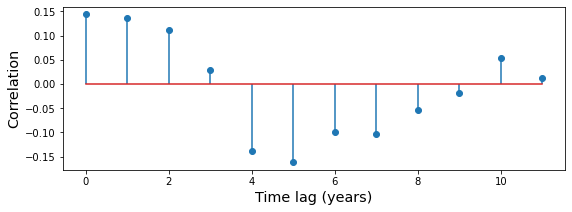

In [48]:
fig = plt.figure()
fsize = 3
plt.gcf().set_size_inches(fsize*3,fsize)

plt.stem( lags, corr_ )
#plt.stem( lags, corr_house )
plt.xlabel( 'Time lag (years)' ,fontsize='x-large')
plt.ylabel( 'Correlation' ,fontsize='x-large')


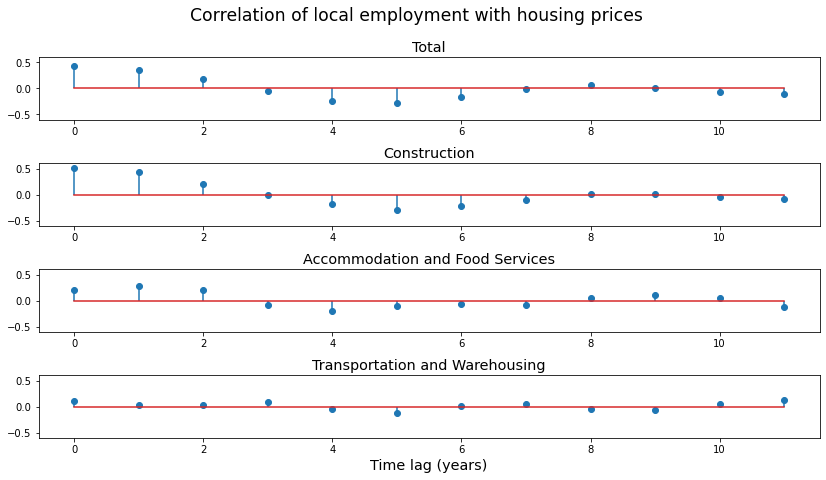

In [79]:
year_range = year_end-year_start-1
max_lag = 12
#corr_ = {}

fig = plt.figure()
fsize = 7
plt.gcf().set_size_inches(fsize*2,fsize)
plt.suptitle( 'Correlation of local employment with housing prices' ,fontsize='xx-large')

#NAICS_codes_sig =  [ '--', '23','44-45','48-49','52','54','62','72' ]
#NAICS_codes_sig =  [ '--', '23','72','44-45','48-49','52','54' ]
NAICS_codes_sig =  [ '--', '23','72','48-49' ]

for i,NAICS_code in enumerate(NAICS_codes_sig):
    lags = []
    corr_ = []
    corr_auto = []
    corr_house = []
    corr_poverty = []



    for lag in range( max_lag ):
        emp_relppc_s = []
        emp_relppc_s_shifted = []
        house_relppc_s = []
        poverty_relppc_s = []
        emp_us_ppc_s = []

        for MSA_rank in available_MSAs:
            MSA = msa_emp_rank_df_dict[ houseRank_to_empRank[MSA_rank] ]


            if NAICS_code in list(tot_empl_all[MSA].columns):
                ppc_relative_state, ppc_relative_country =  ppc_relative(MSA,NAICS_code)
                x=ppc_relative_country.values[:year_range-lag]
                #x=ppc_relative_state.values[:year_range-lag]
                emp_relppc_s += list(x)

                x_shifted = ppc_relative_country.values[lag:year_range]
                #x_shifted = ppc_relative_state.values[lag:year_range]
                emp_relppc_s_shifted += list(x_shifted)

                y1=house_ppc_relative(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
                house_relppc_s += list(y1)

                y2=relative_ppc_poverty(MSA_rank).loc[ list( range(year_start+1,year_end) ) ].values[lag:year_range]
                poverty_relppc_s += list(y2)

                #y3 = tot_empl_state_ppc[ ( 'United States' ,NAICS_code) ].values[lag:year_range]
                #emp_us_ppc_s += list(y3)

        #pcorr = pearsonr(emp_relppc_s,emp_relppc_s_shifted)
        pcorr = pearsonr(emp_relppc_s,house_relppc_s)
        #pcorr = pearsonr(emp_relppc_s,emp_us_ppc_s)
        if len( emp_relppc_s )>40:
            lags += [lag]
            corr_ += [pcorr[0] ]
            
    if len(corr_)>10:
        plt.subplot(  len(NAICS_codes_sig ) ,1,i+1  )
        plt.stem( lags, corr_ )
        #plt.stem( lags, corr_house )
        #plt.xlabel( 'Time lag (years)' ,fontsize='x-large')
        #plt.ylabel( 'Correlation' ,fontsize='x-large')
        plt.title( NAICS_dict[NAICS_code] ,fontsize='x-large')
        plt.ylim( [-0.6,0.6] )
        plt.subplots_adjust(hspace = 0.7)

plt.xlabel( 'Time lag (years)' ,fontsize='x-large')


plt.savefig('data/plots/corr_emp_house_2.png')
